# The Caring Home / Helpful Home Continued

A model that can look for non normal situations in a elderly person home, from smart home IoT sensors.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [1]:
# imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
from items import Item
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

In [26]:
# More imports for our traditional machine learning

import pandas as pd
import numpy as np
#from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction import DictVectorizer
import joblib


## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [27]:
# Finally, more imports for more advanced machine learning
from sklearn.ensemble import RandomForestClassifier

In [28]:
# Constants - used for printing to stdout in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [29]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [30]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [31]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files


In [32]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [33]:
# Remind ourselves the training prompt

print(train[0].prompt)

How would you classify this sensor data - normal or anomalous?

[{"timestamp": 1738684800, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}}, {"timestamp": 1738684860, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}}, {"timestamp": 1738684920, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}, {"timestamp": 1738684980, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}}, {"timestamp": 1738685040, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}]


Result is anomalous


In [34]:
# Remind ourselves the details

print(test[0].details)

[{"timestamp": 1738684800, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}}, {"timestamp": 1738684860, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}}, {"timestamp": 1738684920, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}, {"timestamp": 1738684980, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}}, {"timestamp": 1738685040, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}]



In [35]:
# Remind a test prompt

print(train[0].test_prompt())

How would you classify this sensor data - normal or anomalous?

[{"timestamp": 1738684800, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": true}}}, {"timestamp": 1738684860, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}}, {"timestamp": 1738684920, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}, {"timestamp": 1738684980, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"Event": {"Event": "fridge_opened"}}}, {"timestamp": 1738685040, "room": "kitchen", "nodeId": 2, "endpointId": 1, "attribute": {"OnOff": {"OnOff": false}}}]


Result is 


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against the items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [36]:
class Tester:

    def __init__(self, predictor, data, title=None, size=20):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.colors = []

    def color_for(self, error, truth):
        if not error:
            return "green"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.result
        error = guess != truth
        color = self.color_for(error, truth)
        details = datapoint.details if len(datapoint.details) <= 40 else datapoint.details[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth) 
        self.errors.append(error)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: {guess} Truth: {truth:} Error: {error:} Item: {details}{RESET}")

    def chart(self, title):
        actual = self.truths
        predicted = self.guesses

        # Get unique classes
        classes = list(set(actual + predicted))  # Union of unique classes in actual and predicted

        # Initialize the confusion matrix as a dictionary
        confusion_matrix = {true: {pred: 0 for pred in classes} for true in classes}

        # Populate the confusion matrix
        for a, p in zip(actual, predicted):
            confusion_matrix[a][p] += 1

        # Convert the confusion matrix into a 2D list for visualization
        matrix = [[confusion_matrix[true][pred] for pred in classes] for true in classes]

        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(title)
        plt.colorbar()

        # Add labels
        tick_marks = range(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')

        max_val = max(max(row) for row in matrix) if matrix else 1
        
        # Add text annotations
        for i in range(len(classes)):
            for j in range(len(classes)):
                # Choose white for dark cells and black for lighter cells
                value = matrix[i][j]
                text_color = "white" if value > (max_val * 0.99) else "black"
                plt.text(j, i, value,
                        horizontalalignment="center",
                        color=text_color)

        plt.tight_layout()
        plt.show()


    def report(self):
        average_error = sum(self.errors) / self.size
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error={average_error:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data, size=len(data)).run()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random guess - either normal or anomalous!

In [37]:
def random_anomaly_assessor(item):
    choices = ['normal', 'anomalous']
    choiceNum = random.randint(0,1)
    choice = choices[choiceNum]  
    return choice

In [38]:
print(random_anomaly_assessor(train[1]))

anomalous


1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738684800, "room": "kitc...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739418000, "room": "bath...
3: Guess: anomalous Truth: normal Error: True Item: [{"timestamp": 1738623600, "room": "bath...
4: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738623600, "room": "kitc...
5: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738648800, "room": "bedr...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738758000, "room": "kitc...
7: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738411200, "room": "pill...
8: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738411200, "room": "pill...
9: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1739385600, "room": "bedr...
10: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738797600, "room": "kitc...
11: Guess: normal Truth: anomalous Error: T

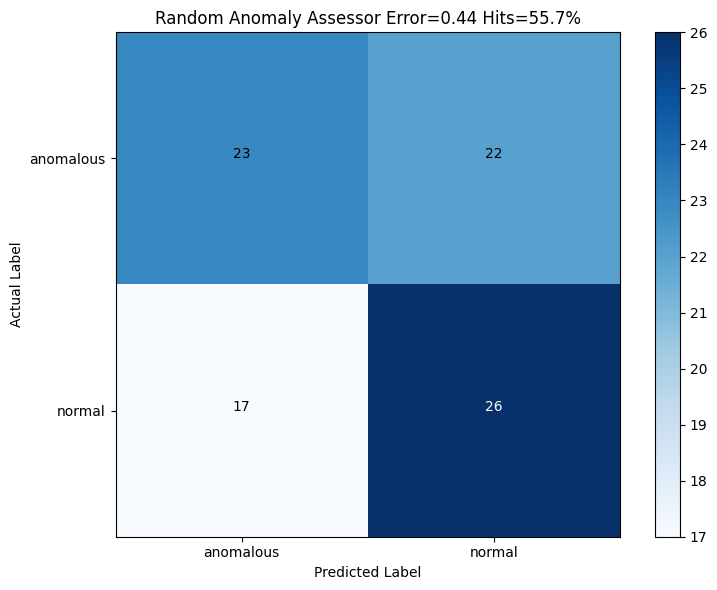

In [39]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_anomaly_assessor, train)

In [40]:
# Now some janky code to pluck out the key features
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!
# This is called "FEATURE ENGINEERING" and is not an exact science!!! 

def prepare_features(data):
    """Convert the raw sensor data into meaningful features dynamically."""
    features = {}
    
    # Load events from data.details (which could be a JSON string, list of JSON strings, or list of dicts)
    if isinstance(data.details, str):
        events = json.loads(data.details)
    elif isinstance(data.details, list) and all(isinstance(item, str) for item in data.details):
        events = [json.loads(event) for event in data.details]
    else:  
        events = data.details

    # Dynamic room counts: count visits for every room seen in the events
    room_counts = {}
    for event in events:
        room = event.get('room')
        if room is not None:
            room_counts[room] = room_counts.get(room, 0) + 1
    # Add dynamic room count features (keys will be like 'room_kitchen_visits', etc.)
    for room, count in room_counts.items():
        features[f'room_{room}_visits'] = count

    # Timestamp based features:
    # Calculate average and maximum time between consecutive events
    timestamps = [event.get('timestamp') for event in events if 'timestamp' in event]
    if len(timestamps) > 1:
        diffs = np.diff(timestamps)
        features['avg_time_between_events'] = float(np.mean(diffs))
        features['max_time_between_events'] = float(np.max(diffs))
    else:
        features['avg_time_between_events'] = 0.0
        features['max_time_between_events'] = 0.0
    
    # Count rapid transitions (events less than 2 minutes apart)
    rapid_transitions = 0
    for i in range(len(timestamps) - 1):
        if timestamps[i+1] - timestamps[i] < 120:
            rapid_transitions += 1
    features['rapid_transitions'] = rapid_transitions

    # Attribute features:
    # For each attribute present, create a feature (e.g., "TemperatureMeasurement_MeasuredValue")
    # and aggregate by taking the average value for that attribute over the period.
    attr_values = {}  # key: feature name, value: list of measurements
    for event in events:
        attr = event.get('attribute', {})
        # Each event's attribute is assumed to be a dict with a single key
        for attr_name, inner in attr.items():
            # inner is a dict (e.g., {"MeasuredValue": 1901} or {"Occupancy": 1})
            for inner_key, value in inner.items():
                feature_key = f"{attr_name}_{inner_key}"
                try:
                    numeric_value = float(value)
                except (ValueError, TypeError):
                    continue
                if feature_key not in attr_values:
                    attr_values[feature_key] = []
                attr_values[feature_key].append(numeric_value)
    
    # Compute the average for each attribute feature if available
    for key, values in attr_values.items():
        features[key] = float(np.mean(values))
    
    return features


In [41]:
#Function to get the features of each datapoint
def get_features(item):
    """Get the datapoints features."""
    features = prepare_features(item)

    return features

In [42]:

get_features(test[0])

{'room_kitchen_visits': 5,
 'avg_time_between_events': 60.0,
 'max_time_between_events': 60.0,
 'rapid_transitions': 4,
 'OnOff_OnOff': 0.3333333333333333}

In [43]:
# Look at features in a training item
get_features(train[6])


{'room_pillbox_visits': 1,
 'room_bedroom_visits': 20,
 'room_bathroom_visits': 3,
 'room_kitchen_visits': 3,
 'avg_time_between_events': 2446.153846153846,
 'max_time_between_events': 3600.0,
 'rapid_transitions': 2,
 'OnOff_OnOff': 0.7142857142857143,
 'RelativeHumidityMeasurement_MeasuredValue': 6500.0,
 'OccupancySensing_Occupancy': 1.0}

In [53]:
#Train the model using Random Forest to fit the classification
def train_anomaly_detector(json_data):
    """Train a machine learning model to detect anomalies."""
    
    # Collect feature dictionaries and labels
    X_dict = []  # List of feature dictionaries
    y = []       # Labels
    
    for entry in json_data:
        features = prepare_features(entry)
        X_dict.append(features)
        y.append(1 if entry.result == 'anomalous' else 0)
    
    # Convert dictionary features to a numerical matrix
    vec = DictVectorizer(sparse=False)
    X = vec.fit_transform(X_dict)
    y = np.array(y)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate the model
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    
    return model, scaler, vec  # Optionally return vec for future transformation

In [54]:
for i in train:
    print(i)

<$anomalous>
<$normal>
<$normal>
<$normal>
<$anomalous>
<$normal>
<$anomalous>
<$anomalous>
<$anomalous>
<$normal>
<$anomalous>
<$anomalous>
<$normal>
<$normal>
<$anomalous>
<$anomalous>
<$anomalous>
<$anomalous>
<$anomalous>
<$normal>
<$normal>
<$normal>
<$anomalous>
<$anomalous>
<$anomalous>
<$anomalous>
<$normal>
<$normal>
<$normal>
<$normal>
<$anomalous>
<$normal>
<$normal>
<$anomalous>
<$anomalous>
<$anomalous>
<$anomalous>
<$normal>
<$normal>
<$anomalous>
<$anomalous>
<$anomalous>
<$normal>
<$anomalous>
<$anomalous>
<$anomalous>
<$anomalous>
<$normal>
<$normal>
<$normal>
<$normal>
<$normal>
<$anomalous>
<$normal>
<$normal>
<$normal>
<$normal>
<$anomalous>
<$normal>
<$normal>
<$normal>
<$normal>
<$normal>
<$normal>
<$normal>
<$normal>
<$normal>
<$anomalous>
<$anomalous>
<$anomalous>
<$anomalous>
<$normal>
<$anomalous>
<$normal>
<$anomalous>
<$normal>
<$normal>
<$anomalous>
<$anomalous>
<$anomalous>
<$anomalous>
<$normal>
<$anomalous>
<$anomalous>
<$normal>
<$anomalous>
<$anomalous

In [55]:
# Train the model
model, scaler, vec = train_anomaly_detector(train)

              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.73      0.84        11

    accuracy                           0.83        18
   macro avg       0.85      0.86      0.83        18
weighted avg       0.88      0.83      0.83        18



In [57]:
def predict_anomaly(model, scaler, vec, new_data):
    # Generate features from the new data
    features = prepare_features(new_data)
    # Use the same vectorizer to transform the feature dictionary
    X = vec.transform([features])
    # Scale the transformed features
    X_scaled = scaler.transform(X)
    prediction = model.predict(X_scaled)
    probability = model.predict_proba(X_scaled)
    return {"is_anomalous": bool(prediction[0]), "probability": probability[0]}

def random_forest_anomaly_assessor(item):
    # Use the vectorizer (vec) returned from training
    result = predict_anomaly(model, scaler, vec, item)
    return 'anomalous' if result['is_anomalous'] else 'normal'

1: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738684800, "room": "kitc...
2: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738238400, "room": "pill...
3: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739170800, "room": "pill...
4: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1739089200, "room": "bedr...
5: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1739374800, "room": "bath...
6: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738734000, "room": "pill...
7: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1739277600, "room": "kitc...
8: Guess: anomalous Truth: anomalous Error: False Item: [{"timestamp": 1739336400, "room": "bedr...
9: Guess: normal Truth: normal Error: False Item: [{"timestamp": 1738623600, "room": "kitc...
10: Guess: normal Truth: anomalous Error: True Item: [{"timestamp": 1738623600, "room": "hall...
11: Guess: anomalous Truth: anomalous

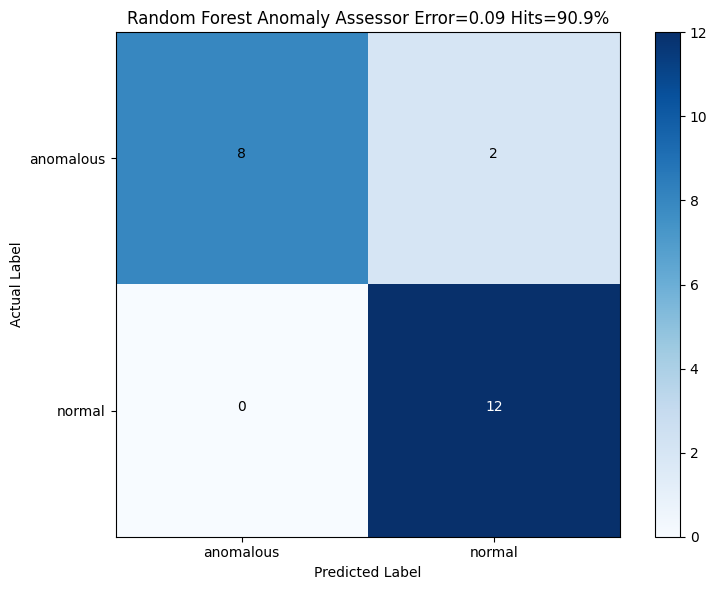

In [59]:
# test it using Random Forest
Tester.test(random_forest_anomaly_assessor, test)


# Now we should save our classification model

In [61]:
# Save the model and scaler to a file

joblib.dump((model, scaler, vec), 'random_forest_model.pkl')

['random_forest_model.pkl']